In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)

In [2]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from itertools import product
from datetime import datetime
from scipy import stats
from sklearn.metrics import mean_squared_error

In [3]:
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.stattools import adfuller

# import statsmodels.formula.api as smf
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./data/btc_daily_all.csv', parse_dates=['Date'], \
                 index_col='Date', date_parser=dateparse)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [4]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.shape

(2975, 1)

In [5]:
df = df.loc[df.index > '2011-12-31']
df.columns = ['Price']
df.head()

,Price
Date,
2012-01-01,5.27
2012-01-02,5.22
2012-01-03,4.88
2012-01-04,5.57
2012-01-05,6.95


In [6]:
print(df.describe())
print('===================')
print(df.dtypes)

              Price
count   2442.000000
mean    1701.009751
std     3143.328980
min        4.220000
25%      135.000000
50%      423.894989
75%      957.307511
max    19345.490234
Price    float64
dtype: object


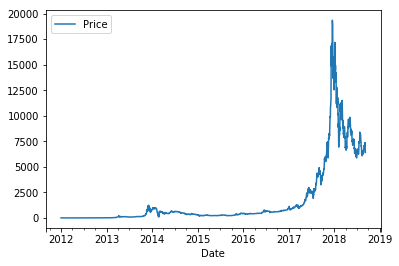

In [7]:
df.plot()

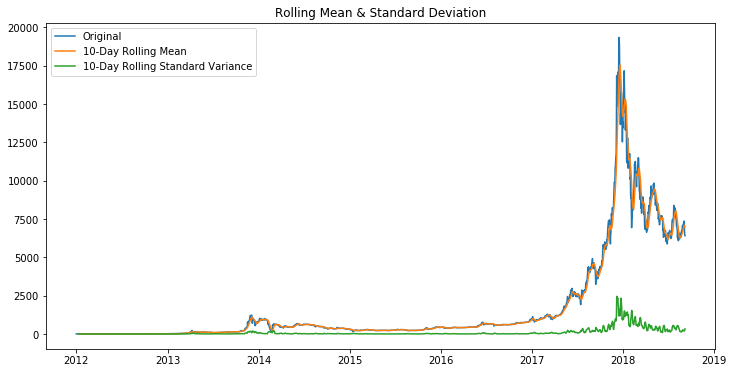

In [8]:
plt.figure(figsize=(12,6))
rolmean = df['Price'].rolling(window=10).mean()
rolvar = df['Price'].rolling(window=10).std()
plt.plot(df['Price'], label='Original')
plt.plot(rolmean, label='10-Day Rolling Mean')
plt.plot(rolvar, label='10-Day Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [9]:
df_month = df.resample('M').mean()
df_qrt   = df.resample('Q-DEC').mean()
df_year  = df.resample('A-DEC').mean()

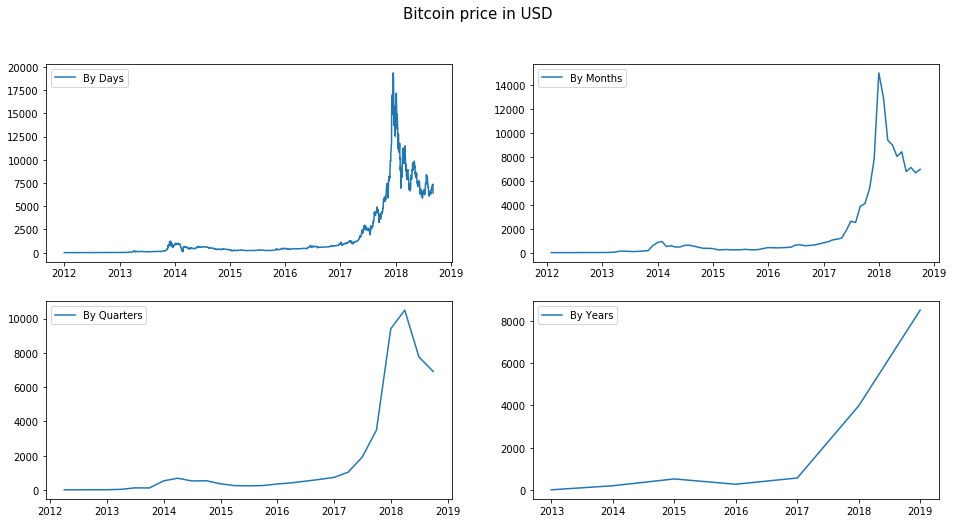

In [10]:
fig = plt.figure(figsize=[16, 8])
plt.suptitle('Bitcoin price in USD', fontsize=15)
plt.subplot(221)
plt.plot(df.Price, '-', label='By Days')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='By Months')
plt.legend()
plt.subplot(223)
plt.plot(df_qrt.Price, '-', label='By Quarters')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='By Years')
plt.legend()
# plt.tight_layout()
plt.show()

In [11]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [12]:
test_stationarity(df['Price'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.643327
p-value                           0.460523
#lags Used                       27.000000
Number of Observations Used    2414.000000
Critical Value (1%)              -3.433062
Critical Value (5%)              -2.862738
Critical Value (10%)             -2.567408
dtype: float64


In [13]:
test_stationarity(df_month['Price'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.386962
p-value                         0.588510
#lags Used                      1.000000
Number of Observations Used    79.000000
Critical Value (1%)            -3.515977
Critical Value (5%)            -2.898886
Critical Value (10%)           -2.586694
dtype: float64


Decomposition of time series: Monthly


<Figure size 576x864 with 0 Axes>

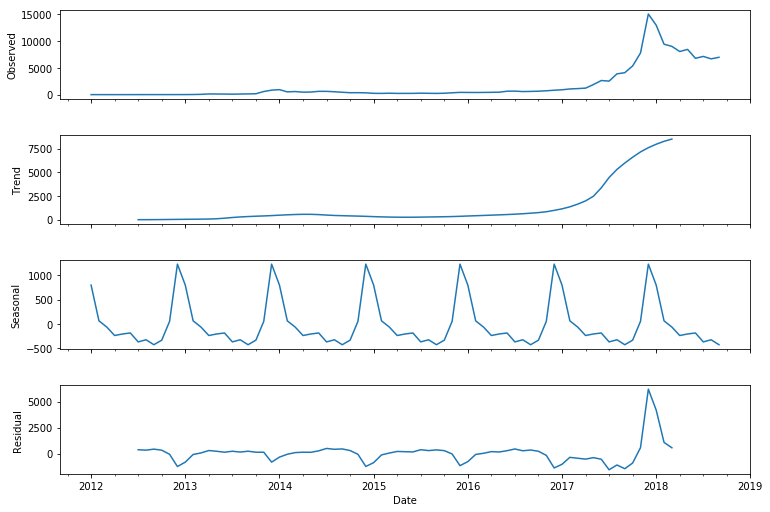

In [14]:
plt.figure(figsize=(8,12))
decomposition = sm.tsa.seasonal_decompose(df_month['Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Monthly')
plt.show()

In [15]:
log_dfm = df_month.copy()
log_dfm.columns = ['Log.Price']
log_dfm['Log.Price'] = np.log(log_dfm['Log.Price'])
log_dfm.head()

,Log.Price
Date,
2012-01-31,1.810982
2012-02-29,1.630592
2012-03-31,1.589630
2012-04-30,1.607102
2012-05-31,1.623850


In [16]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(log_dfm['Log.Price'])[1])
test_stationarity(log_dfm['Log.Price'])

Dickey–Fuller test: p=0.283306
Results of Dickey-Fuller Test:
Test Statistic                 -2.007473
p-value                         0.283306
#lags Used                      7.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


Decomposition of time series: Monthly Log


<Figure size 2160x864 with 0 Axes>

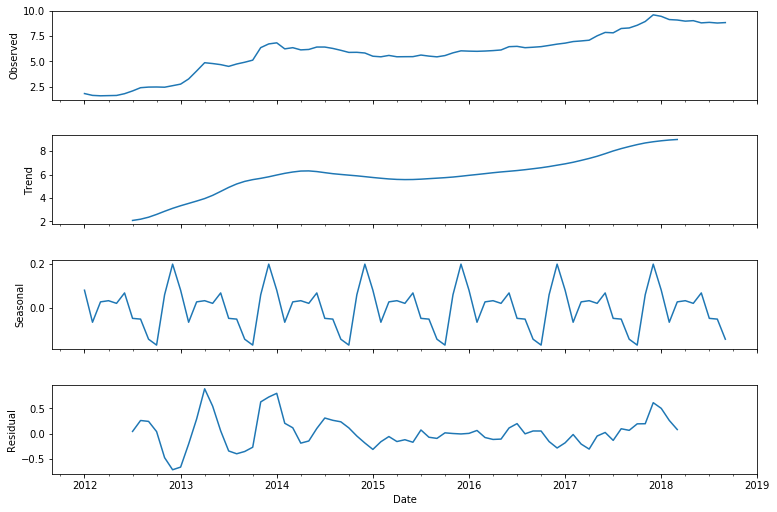

In [17]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(log_dfm['Log.Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Monthly Log')
plt.show()

In [18]:
ret_log_dfm = log_dfm.copy()
ret_log_dfm.columns = ['Ret.Log.Price']
ret_log_dfm['Ret.Log.Price'] = ret_log_dfm['Ret.Log.Price'].diff()
ret_log_dfm = ret_log_dfm.iloc[1:]
ret_log_dfm.head(2)

,Ret.Log.Price
Date,
2012-02-29,-0.180390
2012-03-31,-0.040962


In [19]:
test_stationarity(ret_log_dfm['Ret.Log.Price'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.816838
p-value                         0.372135
#lags Used                      6.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


Decomposition of time series: Monthly Log Return


<Figure size 2160x864 with 0 Axes>

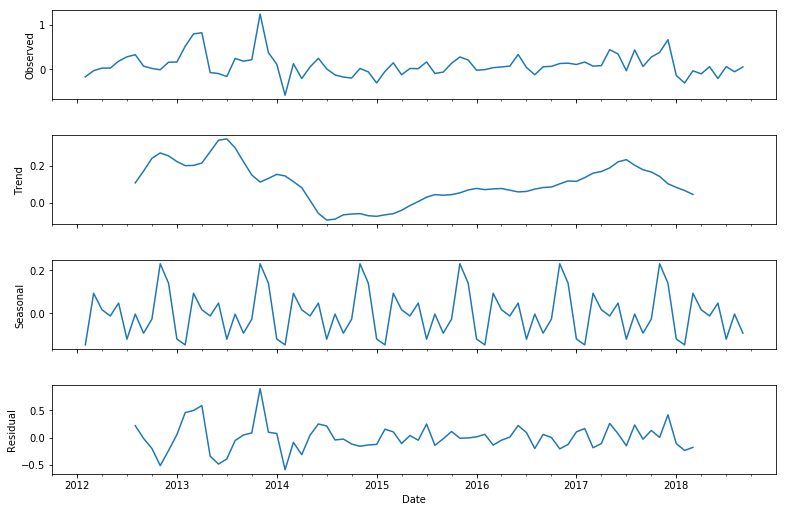

In [20]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(ret_log_dfm['Ret.Log.Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Monthly Log Return')
plt.show()

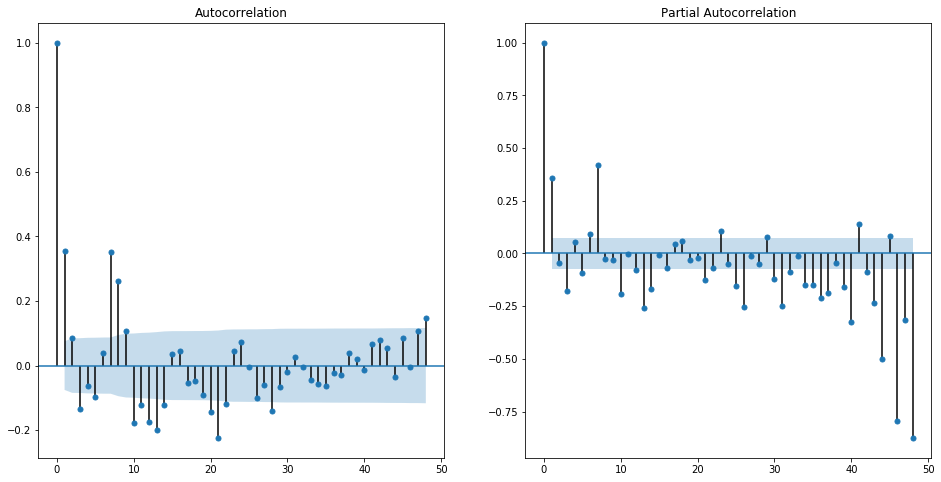

In [21]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(8)
smt.graphics.plot_acf(ret_log_dfm['Ret.Log.Price'], lags=48, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ret_log_dfm['Ret.Log.Price'], lags=48, ax=axes[1], alpha=0.5)
# plt.tight_layout()
plt.show()

In [21]:
Ps = range(0,3)
ps = range(0,3)
Qs = range(0,2)
qs = range(0,3)
Ds = 1
ds = 1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))
parameters_list[:10]

54


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1)]

In [22]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    print(param)
    try:
        model=sm.tsa.statespace.SARIMAX(log_dfm['Log.Price'], order=(param[0], ds, param[1]), \
                                        seasonal_order=(param[2], Ds, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        print('Update!!!')
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

(0, 0, 0, 0)
Update!!!
(0, 0, 0, 1)
Update!!!
(0, 0, 1, 0)
(0, 0, 1, 1)
Update!!!
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
Update!!!
(0, 1, 1, 0)
(0, 1, 1, 1)
Update!!!
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
Update!!!
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 2, 0)
(0, 2, 2, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 2, 0)
(1, 0, 2, 1)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 1, 2, 0)
(1, 1, 2, 1)
(1, 2, 0, 0)
(1, 2, 0, 1)
Update!!!
(1, 2, 1, 0)
(1, 2, 1, 1)
(1, 2, 2, 0)
(1, 2, 2, 1)
(2, 0, 0, 0)
(2, 0, 0, 1)
(2, 0, 1, 0)
(2, 0, 1, 1)
(2, 0, 2, 0)
(2, 0, 2, 1)
(2, 1, 0, 0)
wrong parameters: (2, 1, 0, 0)
(2, 1, 0, 1)
wrong parameters: (2, 1, 0, 1)
(2, 1, 1, 0)
wrong parameters: (2, 1, 1, 0)
(2, 1, 1, 1)
wrong parameters: (2, 1, 1, 1)
(2, 1, 2, 0)
wrong parameters: (2, 1, 2, 0)
(2, 1, 2, 1)
wrong parameters: (2, 1, 2, 1)
(2, 2, 0, 0)
(2, 2, 0, 1)
(2, 2, 1, 0)
(2, 2, 1, 1)
(2, 2, 2, 0)
(2, 2, 2, 1)


In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
31  (1, 2, 0, 1)  25.419766
33  (1, 2, 1, 1)  26.121998
43  (2, 2, 0, 1)  26.596320
13  (0, 2, 0, 1)  27.398996
35  (1, 2, 2, 1)  28.108134
                                 Statespace Model Results                                 
Dep. Variable:                          Log.Price   No. Observations:                   81
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood                  -7.710
Date:                            Wed, 19 Sep 2018   AIC                             25.420
Time:                                    10:22:19   BIC                             36.517
Sample:                                01-31-2012   HQIC                            29.817
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

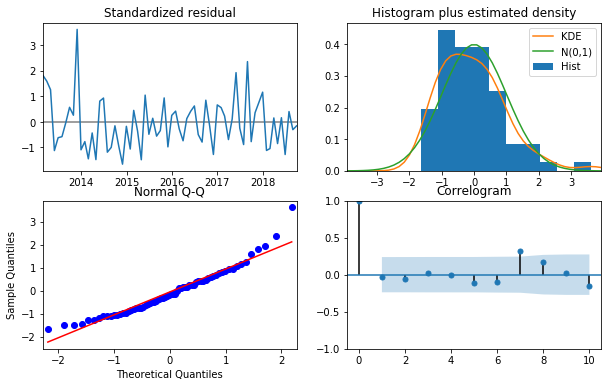

In [24]:
best_model.plot_diagnostics(figsize=(10,6))
plt.show()

Dickey–Fuller test:: p=0.440529


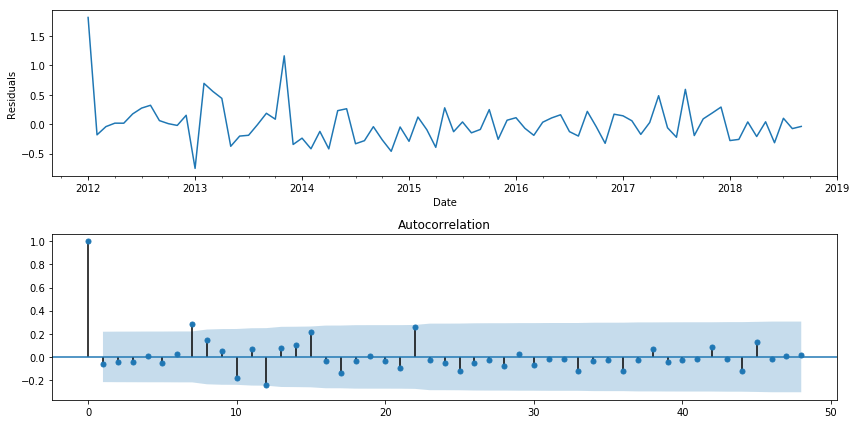

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(211)
best_model.resid[0:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid, lags=48, ax=ax)
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
plt.tight_layout()
plt.show()

In [27]:
print(df_month.head(2))
print(df_month.tail(2))
df_month.shape

               Price
Date                
2012-01-31  6.116452
2012-02-29  5.106897
                  Price
Date                   
2018-08-31  6675.934870
2018-09-30  6968.122698


(81, 1)

In [28]:
best_model.predict(start=75, end=85)

2018-04-30    9.201645
2018-05-31    8.999662
2018-06-30    9.135804
2018-07-31    8.771451
2018-08-31    8.881118
2018-09-30    8.886960
2018-10-31    8.832334
2018-11-30    9.185821
2018-12-31    9.419337
2019-01-31    9.387901
2019-02-28    9.312961
Freq: M, dtype: float64

In [29]:
pred_log = pd.DataFrame(best_model.predict(start=0, end=86))
pred_log.index.name = 'Date'
pred_log.columns = ['Pred.Log.Price']
# pred_log['Pred.Log.Price'] = pred_log['Pred.Log.Price'].shift(-1)
# pred_log = pred_log.iloc[:-1]
print(pred_log.shape)

(87, 1)


In [30]:
pred_log_ci = best_model.get_forecast(steps=7).conf_int()
# pred_log_ci = pred_log_ci.shift(-1)
# pred_log_ci = pred_log_ci.iloc[:-1]
pred_log_ci

,lower Log.Price,upper Log.Price
2018-10-31,8.349664,9.315005
2018-11-30,8.327805,10.043838
2018-12-31,8.188907,10.649767
2019-01-31,7.921897,10.853905
2019-02-28,7.628001,10.997921
2019-03-31,7.594049,11.334195
2019-04-30,7.490883,11.575260


In [31]:
pred_log.tail(10)

,Pred.Log.Price
Date,
2018-06-30,9.135804
2018-07-31,8.771451
2018-08-31,8.881118
2018-09-30,8.886960
2018-10-31,8.832334
2018-11-30,9.185821
2018-12-31,9.419337
2019-01-31,9.387901
2019-02-28,9.312961


In [32]:
log_dfm.tail(6)

,Log.Price
Date,
2018-04-30,8.992479
2018-05-31,9.040481
2018-06-30,8.821354
2018-07-31,8.871806
2018-08-31,8.806265
2018-09-30,8.849101


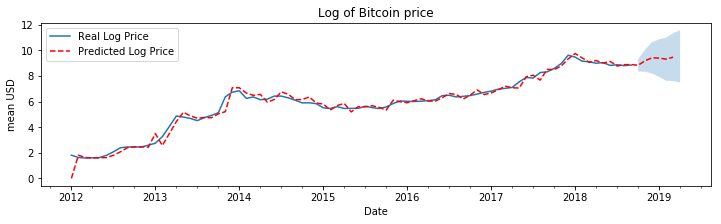

In [33]:
plt.figure(figsize=(12,3))
log_dfm['Log.Price'].plot(label='Real Log Price')
pred_log['Pred.Log.Price'].plot(color='r', ls='--', label='Predicted Log Price') # 'r+', ls='--'
plt.fill_between(pred_log_ci.index, \
                 pred_log_ci.iloc[:,0], \
                 pred_log_ci.iloc[:,1], alpha = 0.25)
plt.legend(loc='best')
plt.title('Log of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

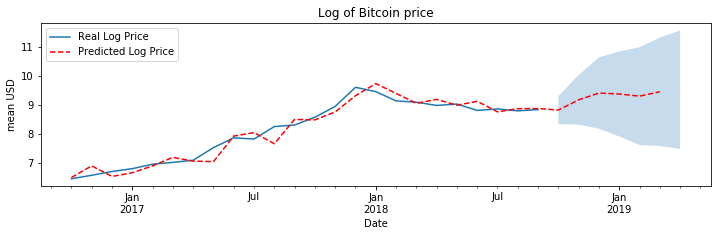

In [34]:
plt.figure(figsize=(12,3))
log_dfm['Log.Price'].iloc[-24:].plot(label='Real Log Price')
pred_log['Pred.Log.Price'].iloc[-30:].plot(color='r', ls='--', label='Predicted Log Price') # 'r+', ls='--'
plt.fill_between(pred_log_ci.index, \
                 pred_log_ci.iloc[:,0], \
                 pred_log_ci.iloc[:,1], alpha = 0.25)
plt.legend(loc='upper left')
plt.title('Log of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [35]:
mse = mean_squared_error(log_dfm['Log.Price'], pred_log['Pred.Log.Price'].iloc[:-6])
mse

0.1214911849325515

In [ ]:
# def invboxcox(y,lmbda):
#     if lmbda == 0:
#         return(np.exp(y))
#     else:
#         return(np.exp(np.log(lmbda*y+1)/lmbda))

In [37]:
pred_price = pred_log.copy()
pred_price.columns = ['Pred.Price']
pred_price['Pred.Price'] = np.exp(pred_price['Pred.Price'])
pred_price.head()

,Pred.Price
Date,
2012-01-31,1.000000
2012-02-29,6.116452
2012-03-31,5.106897
2012-04-30,4.901935
2012-05-31,4.988333


In [38]:
pred_price_ci = pred_log_ci.copy()
pred_price_ci.columns = ['lower Pred.Price', 'upper Pred.Price']
pred_price_ci['lower Pred.Price'] = np.exp(pred_price_ci['lower Pred.Price'])
pred_price_ci['upper Pred.Price'] = np.exp(pred_price_ci['upper Pred.Price'])
pred_price_ci

,lower Pred.Price,upper Pred.Price
2018-10-31,4228.759282,11103.382027
2018-11-30,4137.326641,23013.529920
2018-12-31,3600.785113,42182.761517
2019-01-31,2756.994962,51735.761303
2019-02-28,2054.937640,59749.807885
2019-03-31,1986.340591,83633.144951
2019-04-30,1791.632743,106431.872918


In [39]:
df_month.head(2)

,Price
Date,
2012-01-31,6.116452
2012-02-29,5.106897


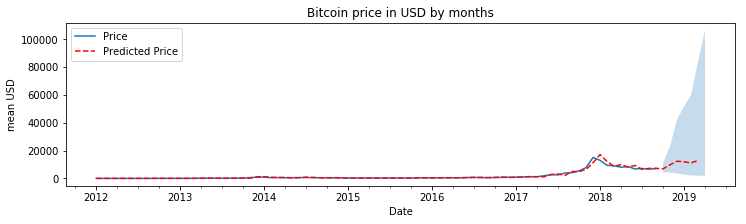

In [40]:
plt.figure(figsize=(12,3))
df_month['Price'].plot()
pred_price['Pred.Price'].plot(color='r', ls='--', label='Predicted Price') # 'r+'
plt.fill_between(pred_price_ci.index, \
                 pred_price_ci.iloc[:,0], \
                 pred_price_ci.iloc[:,1], alpha = 0.25)
plt.legend(loc='upper left')
plt.title('Bitcoin price in USD by months')
plt.ylabel('mean USD')
plt.show()

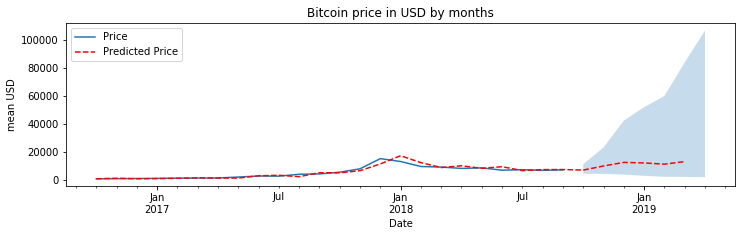

In [41]:
plt.figure(figsize=(12,3))
df_month['Price'].iloc[-24:].plot()
pred_price['Pred.Price'].iloc[-30:].plot(color='r', ls='--', label='Predicted Price') # 'r+'
plt.fill_between(pred_price_ci.index, \
                 pred_price_ci.iloc[:,0], \
                 pred_price_ci.iloc[:,1], alpha = 0.25)
plt.legend(loc='upper left')
plt.title('Bitcoin price in USD by months')
plt.ylabel('mean USD')
plt.show()

In [42]:
mse = mean_squared_error(df_month['Price'], pred_price['Pred.Price'].iloc[:-6])
mse

711815.5211745272

In [43]:
ret_log_dfm = log_dfm.diff().iloc[1:]
ret_log_dfm.columns = ['Ret.Log.Price']
print(ret_log_dfm.head(2))
pred_ret_log = pred_log.diff().iloc[1:]
pred_ret_log.columns = ['Pred.Ret.Log.Price']
print(pred_ret_log.head(2))

            Ret.Log.Price
Date                     
2012-02-29      -0.180390
2012-03-31      -0.040962
            Pred.Ret.Log.Price
Date                          
2012-02-29            1.810982
2012-03-31           -0.180390


In [45]:
pred_log_ci2 = best_model.get_forecast(steps=6).conf_int()
# pred_log_ci2 = pred_log_ci2.shift(-1)
# pred_log_ci2 = pred_log_ci2.iloc[:-1]

In [46]:
pred_ret_log_ci = pred_log_ci2.diff().iloc[1:]
pred_ret_log_ci.columns = ['lower Pred.Ret.Log.Price', 'upper Pred.Ret.Log.Price']
pred_ret_log_ci

,lower Pred.Ret.Log.Price,upper Pred.Ret.Log.Price
2018-11-30,-0.021859,0.728833
2018-12-31,-0.138898,0.605929
2019-01-31,-0.267011,0.204138
2019-02-28,-0.293896,0.144017
2019-03-31,-0.033951,0.336274


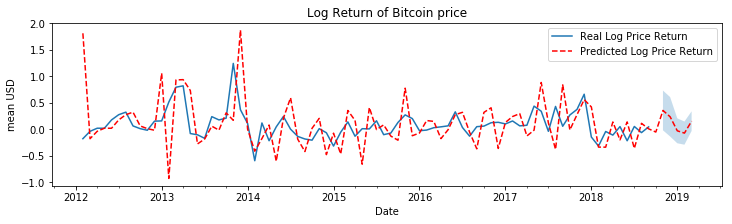

In [47]:
plt.figure(figsize=(12,3))
ret_log_dfm['Ret.Log.Price'].plot(label='Real Log Price Return')
pred_ret_log['Pred.Ret.Log.Price'].plot(color='r', ls='--', label='Predicted Log Price Return') # 'r+', ls='--'
plt.fill_between(pred_ret_log_ci.index, \
                 pred_ret_log_ci.iloc[:,0], \
                 pred_ret_log_ci.iloc[:,1], alpha = 0.25)
plt.legend(loc='best')
plt.title('Log Return of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

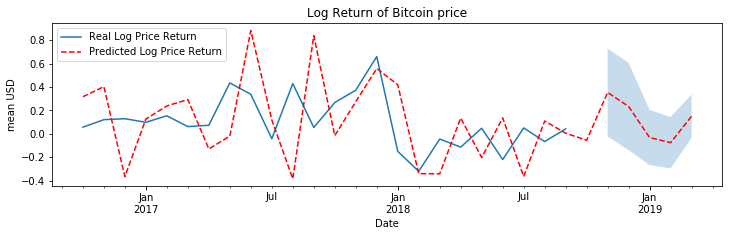

In [49]:
plt.figure(figsize=(12,3))
ret_log_dfm['Ret.Log.Price'].iloc[-24:].plot(label='Real Log Price Return')
pred_ret_log['Pred.Ret.Log.Price'].iloc[-30:].plot(color='r', ls='--', label='Predicted Log Price Return') # 'r+', ls='--'
plt.fill_between(pred_ret_log_ci.index, \
                 pred_ret_log_ci.iloc[:,0], \
                 pred_ret_log_ci.iloc[:,1], alpha = 0.25)
plt.legend(loc='upper left')
plt.title('Log Return of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [50]:
mse = mean_squared_error(pred_ret_log['Pred.Ret.Log.Price'].iloc[:-6], ret_log_dfm['Ret.Log.Price'])
mse

0.221184990302286

In [51]:
sign_check = pd.merge(ret_log_dfm, pred_ret_log, how='left', left_index=True, right_index=True)
print(sign_check.head(2))
print(sign_check.tail(2))
sign_check.shape

            Ret.Log.Price  Pred.Ret.Log.Price
Date                                         
2012-02-29      -0.180390            1.810982
2012-03-31      -0.040962           -0.180390
            Ret.Log.Price  Pred.Ret.Log.Price
Date                                         
2018-08-31      -0.065541            0.109667
2018-09-30       0.042837            0.005842


(80, 2)

In [52]:
sign_check['check'] = sign_check['Ret.Log.Price'] * sign_check['Pred.Ret.Log.Price']
sign_check.head(2)

,Ret.Log.Price,Pred.Ret.Log.Price,check
Date,,,
2012-02-29,-0.180390,1.810982,-0.326684
2012-03-31,-0.040962,-0.180390,0.007389


In [53]:
sign_check['check'] = sign_check['check'].apply(lambda x: 1 if x > 0 else 0)
sign_check.head(2)

,Ret.Log.Price,Pred.Ret.Log.Price,check
Date,,,
2012-02-29,-0.180390,1.810982,0
2012-03-31,-0.040962,-0.180390,1


In [54]:
np.sum(sign_check.check)/sign_check.shape[0], sign_check.shape[0]

(0.575, 80)

In [55]:
print('real + and pred +:', sign_check[sign_check['Ret.Log.Price'] > 0][sign_check['Pred.Ret.Log.Price'] > 0].shape[0])
print('real + and pred -:', sign_check[sign_check['Ret.Log.Price'] > 0][sign_check['Pred.Ret.Log.Price'] < 0].shape[0])
print('real - and pred +:', sign_check[sign_check['Ret.Log.Price'] < 0][sign_check['Pred.Ret.Log.Price'] > 0].shape[0])
print('real - and pred -:', sign_check[sign_check['Ret.Log.Price'] < 0][sign_check['Pred.Ret.Log.Price'] < 0].shape[0])

real + and pred +: 32
real + and pred -: 20
real - and pred +: 14
real - and pred -: 14


In [56]:
32/80, 20/80, 12/40, 14/80

(0.4, 0.25, 0.3, 0.175)